# Dinamika linijske konstrukcije z metodo končnih elementov
Marko Tacer, 23222087

In [167]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,signal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

V spodaj predstavljenem "notebooku" so uporabljene izpeljave za končni elementi palica in nosilec, ki smo jih prikazali na vajah. 

## Priprava linijskega modela

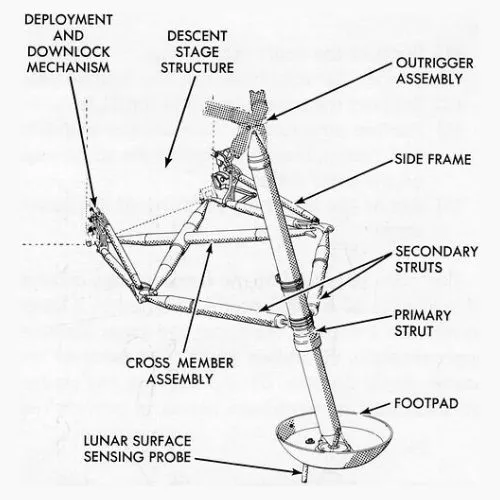

https://apollo11space.com/nasas-apollo-11-lunar-module-basic-facts/

## Osnovna (skupna) geometrija

(-0.2, 4.2)

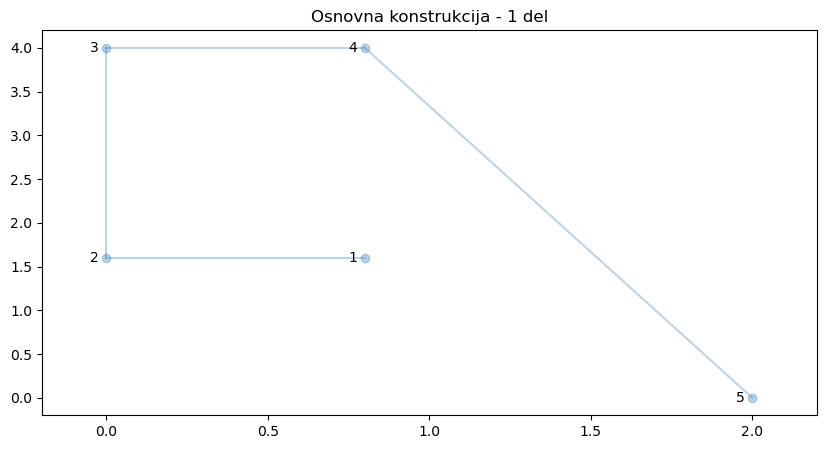

In [168]:
L1 = 2 # m - skupna dolžina
L2 = 4 # m - skupna višina
k1 = 0.4 # razmerje dolžine pritrjene konstrukcije
k2 = 0.4 # razmerje višine pritrjene konstrukcije

# Definicija skupnih vozlišč (5, ki jih že poznamo)
vozlisca_osn_sk = np.array([[k1 * L1, k2 * L2], [0, k2*L2], [0,L2], [k1 * L1, L2], [L1, 0]])

# Dolocitev vmesnega vozlisca
# k3 = 0.6
# y_P = k3*L2
# x_P = (k3*(k1-1) +1)*L1
# vozlisca_osn_sk = np.append(vozlisca_osn_sk, [x_P, y_P])

# Definicija elementov
elementi_osn_sk = np.array([[0, 1],[1, 2], [2, 3], [3, 4]]) #, [0, 5]])
# 
vozlisca_osn_sk = vozlisca_osn_sk.reshape(5, 2)

# Izris
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title('Osnovna konstrukcija - 1 del')
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', color='C0', alpha=0.3)

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.3)
[plt.text(*c,n+1) for n,c in enumerate(vozlisca_osn_sk-0.05)];

ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
# print(vozlisca_osn_sk.shape)   # Output: (3, 2)
# print(elementi_osn_sk.shape)

Definicija funkcije zgoščanja. Sama funkcija omogoča, da posamezni element poljubno zgostimo. Še vedno pa lahko tudi definiramo število pod-elementov za vse elemente enako.

In [169]:
def zgostitev(vozlisca_osn, elementi_osn, number_of_elements = [2]):
    ''' 
    Definiramo osnovna vozlisca : vozlisca_osn
    Definiramo osnovne elemente : elementi_osn
    Definiramo array, ki doloca stevilo elementov na posameznem elementu : number_of_elements
        Če želimo povsod enako definiramo array z enim elementom
        Sicer pa array s številom elementov enakim številu elementov posameznega dela osnovne konstrukcije
    '''
    # Ko želimo povsod enako število elementov
    if len(number_of_elements) == 1:
        
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        
        for i in elementi_osn: 
            x = np.linspace(vozlisca[i[0],0], vozlisca_osn[i[1],0], number_of_elements[0] + 1)[1:-1]
            y = np.linspace(vozlisca[i[0],1], vozlisca_osn[i[1],1], number_of_elements[0] + 1)[1:-1]
            voz = np.column_stack((x, y))
            
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([i[0],novi_ind_vozlisc,i[1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)
    
    # Če želimo različno število elementov (Pozor, dolžina number_of_elements mora biti enaka dolžini elementi_osn)
    elif len(number_of_elements) == len(elementi_osn):
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        
        for j in np.arange(len(elementi_osn)):
            x = np.linspace(vozlisca[elementi_osn[j][0],0], vozlisca_osn[elementi_osn[j][1],0], 1 + int(number_of_elements[j]))[1:-1]
            y = np.linspace(vozlisca[elementi_osn[j][0],1], vozlisca_osn[elementi_osn[j][1],1], 1 + int(number_of_elements[j]))[1:-1]
            voz = np.column_stack((x, y))
        
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([elementi_osn[j][0], novi_ind_vozlisc, elementi_osn[j][1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)
    
    # Ko ne izberemo nobene od zgornjih opcij oz ne podamo pravilnega števila elementov
    else:
        print("Error!")
        print("Napačni vhodni podatki!")
        print("Ni zgostitve elementov!")
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        # Ni zgostitve
        number_of_elements = [1]
        
        for i in elementi_osn: 
            x = np.linspace(vozlisca[i[0],0], vozlisca_osn[i[1],0], number_of_elements[0] + 1)[1:-1]
            y = np.linspace(vozlisca[i[0],1], vozlisca_osn[i[1],1], number_of_elements[0] + 1)[1:-1]
            voz = np.column_stack((x, y))
            
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([i[0],novi_ind_vozlisc,i[1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)

Še definicija transformacijske, masne in togostne matrike za okvir in paličje.

In [170]:
# OKVIR
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

# masna matrika
def M_o(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

# togostna matrika
def K_o(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

In [171]:
# PALIČJE

# masna matrika
def M_p(A, L, ρ):

    M = ρ*A*L/6*np.array([
    [2, 0, 1, 0],
    [0, 2, 0, 1],
    [1, 0, 2, 0],
    [0, 1, 0, 2]])
    
    return M

def K_p(A, E, L, α):

    c = np.cos(α)
    s = np.sin(α)
    
    K = A*E/L*np.array([
    [ c**2,   s*c, -c**2,  -s*c],
    [  s*c,  s**2,  -s*c, -s**2],
    [-c**2,  -s*c,  c**2,   s*c],
    [ -c*s, -s**2,   s*c,  s**2]])
    
    return K

## Struktura 1

Našo strukturo 1 predstavljajo prva 4 vozlišča skupne strukture. Prav tako si elementi strukture A prvi trije iz skupne konstrukcije.

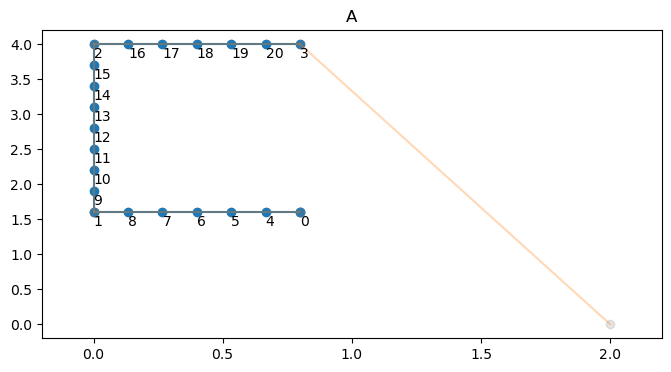

In [172]:
vozlisca_osn_A = vozlisca_osn_sk[:4]
elementi_osn_A = elementi_osn_sk[:3]

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("A")
for i in vozlisca_osn_A[:-2]:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_A:
    x = [vozlisca_osn_A[element[0], 0], vozlisca_osn_A[element[1], 0]]
    y = [vozlisca_osn_A[element[0], 1], vozlisca_osn_A[element[1], 1]]
    ax.plot(x, y, 'C0')


ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)

vozlisca_A, elementi_A = zgostitev(vozlisca_osn_A, elementi_osn_A, [6, 8, 6])

for i in np.arange(len(vozlisca_A)):
    ax.plot(vozlisca_A[i][0], vozlisca_A[i][1], 'o', color='C0')
[ax.text(*c,n) for n,c in enumerate(vozlisca_A-[0, 0.2])];

# Izris backup strukture
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.2, color="gray")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)

In [173]:
2.82*100*100*100 /1000

2820.0

In [174]:
# Podstruktura A - okvir

# Definiramo okrolo cev, iz 7178-T6 aluminija
h = 0.005 # m - debelina stene
D = 0.2 # m - zunanji premer
d = D-2*h # m - notranji premer

ρ_A = 2.82*1000 # kg /m3
E_A = 80e9 # Aluminij 7178-T6

# Votli okrogli profil
A_A = np.pi * ((D/2)**2 - (d/2)**2)
I_A = np.pi/4 * (D**4 - d**4)

# zlaganje
n_ps_A = 3*len(vozlisca_A)
M_glob_A = np.zeros((n_ps_A,n_ps_A))
K_glob_A = np.zeros((n_ps_A,n_ps_A))

for element in elementi_A:
    Le = sp.spatial.distance.euclidean(vozlisca_A[element[0]], vozlisca_A[element[1]])
    αe = np.arctan2(np.diff(vozlisca_A[element,1]) , np.diff(vozlisca_A[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_A[ind[:,None],ind] += M_o(A_A, Le, ρ_A, αe)
    K_glob_A[ind[:,None],ind] += K_o(A_A, E_A, I_A, Le, αe)


print(f'Število osnovnih vozlisc: \t {len(vozlisca_osn_A)}')
print(f'Število osnovnih elementov: \t {len(elementi_osn_A)}')
print(f'Število zgoscenih vozlisc: \t {len(vozlisca_A)}')
print(f'Število zgoscenih elementov: \t {len(elementi_A)}')
print()
print(f'Oblika vozlisca_A : {vozlisca_A.shape}, oblika elementi_A: {elementi_A.shape}')
print(f'Oblika vozlisca_osn_A : {vozlisca_osn_A.shape}, oblika elementi_osn_A: {elementi_osn_A.shape}')
print()
print(f'M_glob_A : {M_glob_A.shape}, \t K_glob_A: {K_glob_A.shape}')
print(f'h[mm] \t\t D[cm] \t\t d[cm] \t\t A[cm2] \t I[cm4] \t ρ[kg/m3] \t E[GPa]')
print(f'{h*1000:.2f} \t\t {D*100:.2f} \t\t {d*100:.2f} \t\t {A_A*10000:.2f} \t\t {I_A*100*4:.2f} \t\t {ρ_A:.2f} \t {E_A/10**9:.2f}')

Število osnovnih vozlisc: 	 4
Število osnovnih elementov: 	 3
Število zgoscenih vozlisc: 	 21
Število zgoscenih elementov: 	 20

Oblika vozlisca_A : (21, 2), oblika elementi_A: (20, 2)
Oblika vozlisca_osn_A : (4, 2), oblika elementi_osn_A: (3, 2)

M_glob_A : (63, 63), 	 K_glob_A: (63, 63)
h[mm] 		 D[cm] 		 d[cm] 		 A[cm2] 	 I[cm4] 	 ρ[kg/m3] 	 E[GPa]
5.00 		 20.00 		 19.00 		 30.63 		 0.09 		 2820.00 	 80.00


## Struktura 2 (C)

Struktura C je v našem primeru zgolj en nosilec, ki je členkasto pritrjen na strukturo A. To je pravzaprav noga, s katero plovilo "stopi" na površino

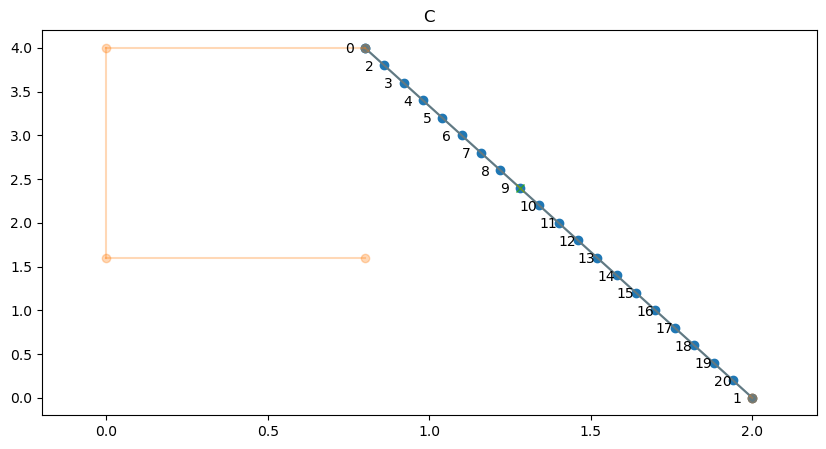

In [175]:
vozlisca_osn_C = vozlisca_osn_sk[-2:]
elementi_osn_C = np.array([[0,1]])
vozlisca_osn_C = vozlisca_osn_C.reshape(2, 2)

fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title("C")

for i in vozlisca_osn_C:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_C:
    x = [vozlisca_osn_C[element[0], 0], vozlisca_osn_C[element[1], 0]]
    y = [vozlisca_osn_C[element[0], 1], vozlisca_osn_C[element[1], 1]]
    ax.plot(x, y, 'C0')

ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)

vozlisca_C, elementi_C = zgostitev(vozlisca_osn_C[:], elementi_osn_C, [20])


for i in np.arange(len(vozlisca_C)):
    ax.plot(vozlisca_C[i][0], vozlisca_C[i][1], 'o', color='C0')
[ax.text(*c, n) for n,c in enumerate(vozlisca_C  - 0.06)];
ax.plot(vozlisca_C[9][0], vozlisca_C[9][1], 'x')

for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3, color="C1")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)

In [176]:
# Podstruktura C - okvir

h = 0.008 # m
D = 0.3 # m
d = D-2*h

ρ_C = ρ_A # kg /m3
E_C = 80e9 # Pa recimo nek specialen Al

A_C = np.pi * ((D/2)**2 - (d/2)**2)
I_C = np.pi/4 * (D**4 - d**4)

# zlaganje
n_ps_C = 3*len(vozlisca_C)
M_glob_C = np.zeros((n_ps_C,n_ps_C))
K_glob_C = np.zeros((n_ps_C,n_ps_C))

for element in elementi_C:
    Le = sp.spatial.distance.euclidean(vozlisca_C[element[0]], vozlisca_C[element[1]])
    αe = np.arctan2(np.diff(vozlisca_C[element,1]) , np.diff(vozlisca_C[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_C[ind[:,None],ind] += M_o(A_C, Le, ρ_C, αe)
    K_glob_C[ind[:,None],ind] += K_o(A_C, E_C, I_C, Le, αe)
    


print(f'Stevilo osnovnih vozlisc: \t {len(vozlisca_osn_C)}')
print(f'Stevilo osnovnih elementov: \t {len(elementi_osn_C)}')
print(f'Stevilo zgoscenih vozlisc: \t {len(vozlisca_C)}')
print(f'Stevilo zgoscenih elementov: \t {len(elementi_C)}')
print()
print(f'Oblika vozlisca_C : {vozlisca_C.shape}, oblika elementi_C: {elementi_C.shape}')
print(f'Oblika vozlisca_osn_C : {vozlisca_osn_C.shape}, oblika elementi_osn_C: {elementi_osn_C.shape}')
print()
print(f'M_glob_C : {M_glob_C.shape}, \t K_glob_C: {K_glob_C.shape}')
print(f'h[mm] \t\t D[cm] \t\t d[cm] \t\t A[cm2] \t I[cm4] \t ρ[kg/m3] \t E[GPa]')
print(f'{h*1000:.2f} \t\t {D*100:.2f} \t\t {d*100:.2f} \t\t {A_C*10000:.2f} \t\t {I_C*100*4:.2f} \t\t {ρ_C:.2f} \t {E_C/10**9:.2f}')

Stevilo osnovnih vozlisc: 	 2
Stevilo osnovnih elementov: 	 1
Stevilo zgoscenih vozlisc: 	 21
Stevilo zgoscenih elementov: 	 20

Oblika vozlisca_C : (21, 2), oblika elementi_C: (20, 2)
Oblika vozlisca_osn_C : (2, 2), oblika elementi_osn_C: (1, 2)

M_glob_C : (63, 63), 	 K_glob_C: (63, 63)
h[mm] 		 D[cm] 		 d[cm] 		 A[cm2] 	 I[cm4] 	 ρ[kg/m3] 	 E[GPa]
8.00 		 30.00 		 28.40 		 73.39 		 0.50 		 2820.00 	 80.00


## Struktura 3 (B)

Pri strukturi B pa definiramo palico. Za povezuje prvo voylišče strukture A in izbrano vozližče na nosilcu C. 

In [177]:
# Na katero vozlišče strukture C se pripenja naša palica (B)
indeks_C = 9;
print(f'Koordinati pripenjališča')
print()
print(f'Vozlišče \t x\t y')
print(f'{indeks_C} \t\t{vozlisca_C[indeks_C][0]:.2f}\t{vozlisca_C[indeks_C][1]:.2f} ')

vozlisca_osn_B = np.hstack((vozlisca_osn_sk[0], vozlisca_C[indeks_C])).reshape(2, 2)
elementi_osn_B = np.array([[0,1]])

vozlisca_B, elementi_B = zgostitev(vozlisca_osn_B[:], elementi_osn_B, [1]) # 1, saj zgostitve pri palici ni smiselno delati

Koordinati pripenjališča

Vozlišče 	 x	 y
9 		1.28	2.40 


In [178]:
vozlisca_B[1, :]

array([1.28, 2.4 ])

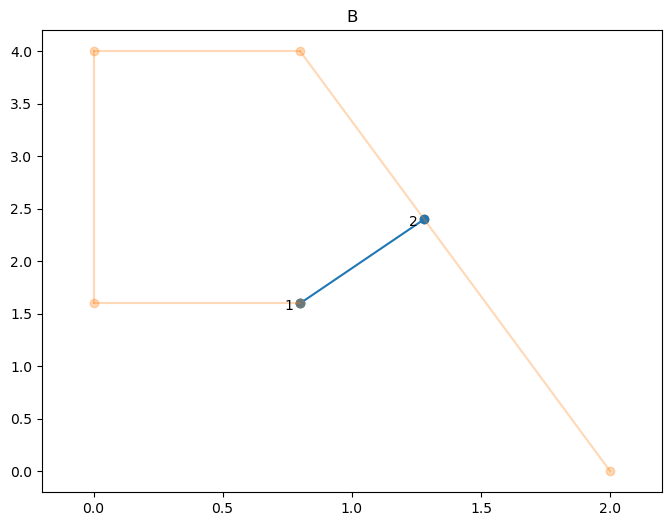

In [179]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title("B")
for i in vozlisca_osn_B:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_B:
    x = [vozlisca_osn_B[element[0], 0], vozlisca_osn_B[element[1], 0]]
    y = [vozlisca_osn_B[element[0], 1], vozlisca_osn_B[element[1], 1]]
    ax.plot(x, y, 'C0')
# [ax.text(*c,n+1) for n,c in enumerate(vozlisca_osn_B-0.05)]
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
for i in np.arange(len(vozlisca_B)):
    ax.plot(vozlisca_B[i][0], vozlisca_B[i][1], 'o', color='C0')
[ax.text(*c, n+1) for n,c in enumerate(vozlisca_B  - 0.06)];

# Izris backup strukture
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3, color="C1")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)



In [180]:
# Podstruktura B - paličje

# recimo, da je palica iz enakeag materiala, le da je profil poln
d = 0.10 # m

ρ_B = ρ_A # kg /m3
E_B = E_A # Pa
A_B = np.pi * d**2 / 4 # m^2

# zlaganje
n_ps_B = 2*len(vozlisca_B)
M_glob_B = np.zeros((n_ps_B,n_ps_B))
K_glob_B = np.zeros((n_ps_B,n_ps_B))

for element in elementi_B:
    Le = sp.spatial.distance.euclidean(vozlisca_B[element[0]], vozlisca_B[element[1]])
    αe = np.arctan2(np.diff(vozlisca_B[element,1]) , np.diff(vozlisca_B[element,0]))[0]
    ind = (2*element[:,None] + np.array([0, 1])).flatten()
    
    M_glob_B[ind[:,None],ind] += M_p(A_B, Le, ρ_B)
    K_glob_B[ind[:,None],ind] += K_p(A_B, E_B, Le, αe)


print(f'Število osnovnih vozlišč: \t {len(vozlisca_osn_B)}')
print(f'Število osnovnih elementov: \t {len(elementi_osn_B)}')
print(f'Število zgoščenih vozlišč: \t {len(vozlisca_B)}')
print(f'Število zgoščenih elementov: \t {len(elementi_B)}')
print()
print(f'Oblika vozlisca_B : {vozlisca_B.shape}, oblika elementi_B: {elementi_B.shape}')
print(f'Oblika vozlisca_osn_B : {vozlisca_osn_B.shape}, oblika elementi_osn_B: {elementi_osn_B.shape}')
print()
print(f'M_glob_B : {M_glob_B.shape}, \t K_glob_B: {K_glob_B.shape}')
print(f'd[cm] \t ρ[kg/m3] \t E[GPa] \t A[cm2]')
print(f'{d*100:.2f} \t {ρ_B:.2f} \t {E_B/10**9:.2f} \t\t {A_B*10000:.2f}')

Število osnovnih vozlišč: 	 2
Število osnovnih elementov: 	 1
Število zgoščenih vozlišč: 	 2
Število zgoščenih elementov: 	 1

Oblika vozlisca_B : (2, 2), oblika elementi_B: (1, 2)
Oblika vozlisca_osn_B : (2, 2), oblika elementi_osn_B: (1, 2)

M_glob_B : (4, 4), 	 K_glob_B: (4, 4)
d[cm] 	 ρ[kg/m3] 	 E[GPa] 	 A[cm2]
10.00 	 2820.00 	 80.00 		 78.54


## Skupna geometrija

Dodamo vozlisce, ki smo si ga izbrali pri strukturi B

In [181]:
vozlisca_osn_sk = np.vstack((vozlisca_osn_sk, vozlisca_B[-1, :]))
elementi_osn_sk = np.vstack((elementi_osn_sk, [0, -1]))


In [182]:
elementi_osn_sk

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 0, -1]])

Skupna (osnovna) vozlišča: 6
Skupni (osnovni) elementi: 5


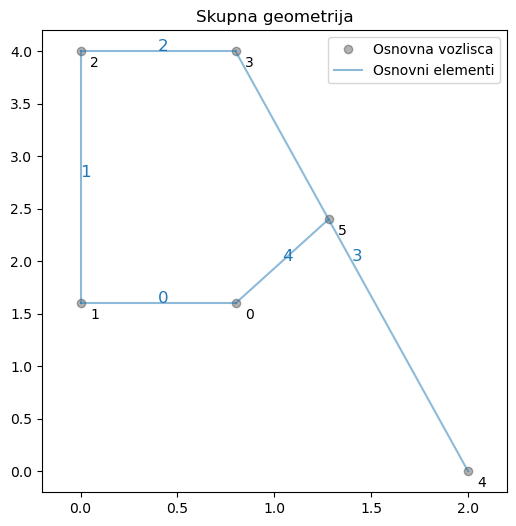

In [183]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title("Skupna geometrija")

for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna vozlisca' if i[0] == 2 else "")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[1] == -1 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_osn_sk-[-0.05, 0.15])];

location_el = np.empty((0,2))
for i in range(len(elementi_osn_sk)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_osn_sk[elementi_osn_sk[i],0])/2, np.sum(vozlisca_osn_sk[elementi_osn_sk[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0], location_el[g, 1]), color='C5', size=10) for g in range(len(elementi_osn_sk))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()

print(f'Skupna (osnovna) vozlišča: {vozlisca_osn_sk.shape[0]}')
print(f'Skupni (osnovni) elementi: {elementi_osn_sk.shape[0]}')

## Diskretiziran sistem

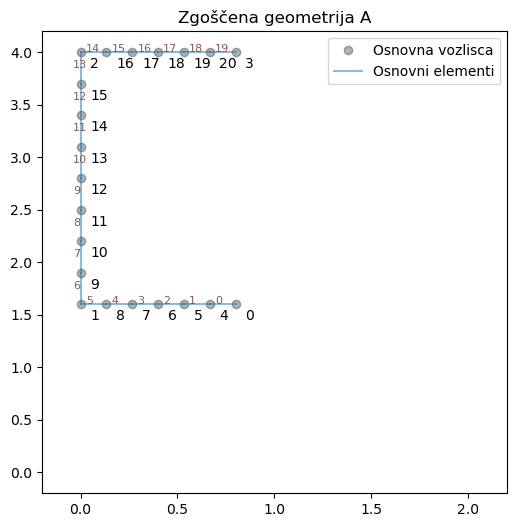

In [184]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title("Zgoščena geometrija A")

for i in vozlisca_A:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna vozlisca' if i[0]+i[1] == 4.8 else "")

for element in elementi_A:
    x = [vozlisca_A[element[0], 0], vozlisca_A[element[1], 0]]
    y = [vozlisca_A[element[0], 1], vozlisca_A[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[0] == 0 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_A-[-0.05, 0.15])];

location_el = np.empty((0,2))
for i in range(len(elementi_A)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_A[elementi_A[i],0])/2, np.sum(vozlisca_A[elementi_A[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0]-0.04, location_el[g, 1]), color='C5', size=8) for g in range(len(elementi_A))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()


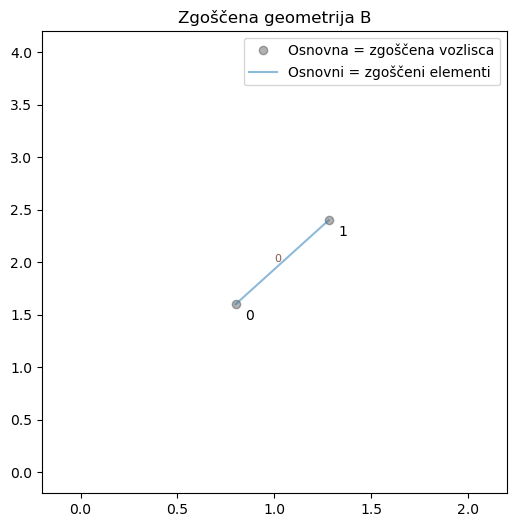

In [185]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title("Zgoščena geometrija B")

for i in vozlisca_B:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna = zgoščena vozlisca' if i[0] == 0.8 else "")

for element in elementi_B:
    x = [vozlisca_B[element[0], 0], vozlisca_B[element[1], 0]]
    y = [vozlisca_B[element[0], 1], vozlisca_B[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni = zgoščeni elementi' if element[1] == 1 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_B-[-0.05, 0.15])];

location_el = np.empty((0,2))
for i in range(len(elementi_B)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_B[elementi_B[i],0])/2, np.sum(vozlisca_B[elementi_B[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0]-0.04, location_el[g, 1]), color='C5', size=8) for g in range(len(elementi_B))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()


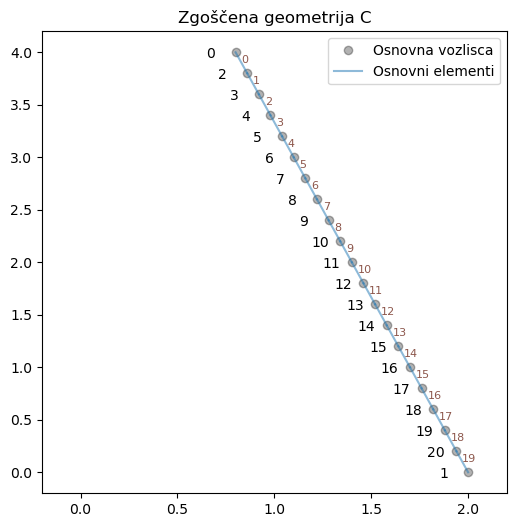

In [186]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title("Zgoščena geometrija C")

for i in vozlisca_C:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Osnovna vozlisca' if i[0] == 2 else "")

for element in elementi_C:
    x = [vozlisca_C[element[0], 0], vozlisca_C[element[1], 0]]
    y = [vozlisca_C[element[0], 1], vozlisca_C[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[1] == 1 else "")
[ax.text(*c,n) for n, c in enumerate(vozlisca_C+[-0.15, -0.05])];

location_el = np.empty((0,2))
for i in range(len(elementi_C)):
    location_el=np.append(location_el, np.array([[np.sum(vozlisca_C[elementi_C[i],0])/2, np.sum(vozlisca_C[elementi_C[i], 1])/2]]),axis=0)

[ax.annotate(g, (location_el[g, 0], location_el[g, 1]), color='C5', size=8) for g in range(len(elementi_C))];
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
ax.legend()


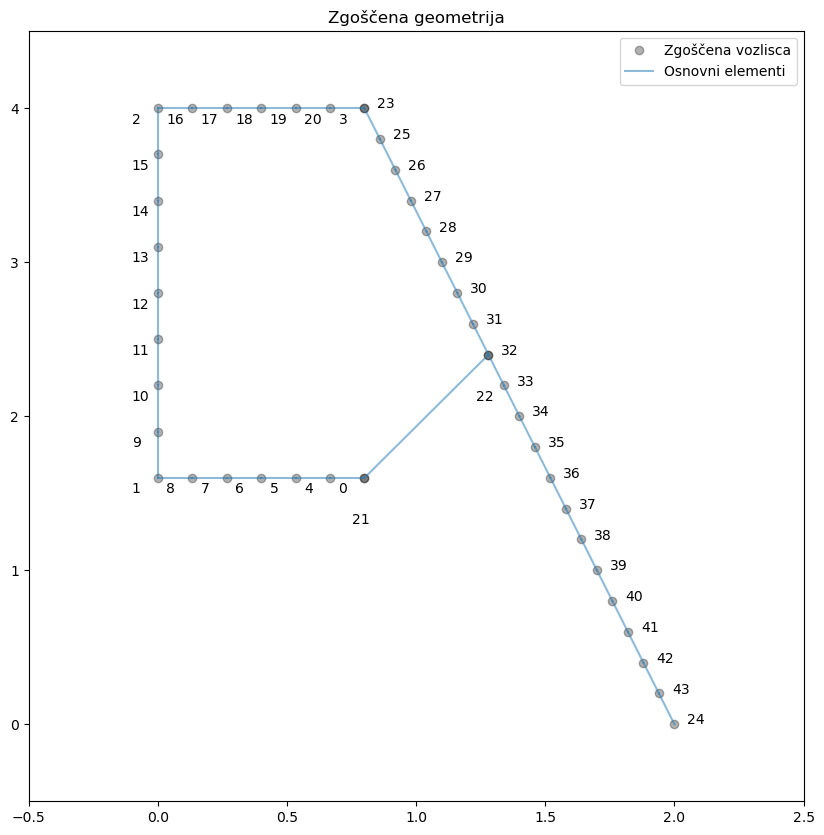

In [187]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_title("Zgoščena geometrija")

v = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
e  = np.vstack((elementi_A, elementi_B, elementi_C))
for i in v:
    ax.plot(i[0], i[1], 'o', color='black', alpha=0.3, label='Zgoščena vozlisca' if i[0] == 2 else "")

for element in elementi_A:
    x = [vozlisca_A[element[0], 0], vozlisca_A[element[1], 0]]
    y = [vozlisca_A[element[0], 1], vozlisca_A[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5)#, label='Osnovni elementi' if element[1] == 1 else "")

for element in elementi_B:
    x = [vozlisca_B[element[0], 0], vozlisca_B[element[1], 0]]
    y = [vozlisca_B[element[0], 1], vozlisca_B[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5)#, label='Osnovni elementi' if element[1] == 1 else "")

for element in elementi_C:
    x = [vozlisca_C[element[0], 0], vozlisca_C[element[1], 0]]
    y = [vozlisca_C[element[0], 1], vozlisca_C[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.5, label='Osnovni elementi' if element[1] == 1 else "")

[ax.text(*c,n) for n, c in enumerate(v[:len(vozlisca_A), :]-[0.1, 0.1])];
[ax.text(*c,n+len(vozlisca_A)) for n, c in enumerate(v[len(vozlisca_A):len(vozlisca_A)+len(vozlisca_B), :]-[0.05, 0.3])];
[ax.text(*c,n+len(vozlisca_A)+len(vozlisca_B)) for n, c in enumerate(v[-len(vozlisca_C):, :] + [0.05, 0])];

# [ax.annotate(g, (location_el[g, 0], location_el[g, 1]), color='C5', size=8) for g in range(len(e[:len(elementi_A)]))];
# [ax.annotate("g", (1, 2), color='C5', size=8)];
# [ax.annotate(g + len(elementi_A), (location_el[g + len(elementi_A), 0], location_el[g + len(elementi_A), 1]), color='C5', size=8) for g in range(len(e[len(elementi_A):(len(elementi_A)+len(elementi_B))]))];
# [ax.annotate(g + len(elementi_A) + len(elementi_B), (location_el[g, 0], location_el[g, 1]), color='C5', size=8) for g in range(len(e[:len(elementi_B)]))];
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 4.5)

ax.legend();


## Robni pogoji

V naslednjem poglavju definiramo robne pogoje in pogoje konsistentnega prehoda. Ker imam tri strukture in robne pogoje samo pri dveh je potrebno samo skupno matriko C malo prilagoditi.

In [188]:
# A - robni pogoji
ind_vpetih_ps_A = np.array([3, 4, 6, 7]) # definiramo dva vozlišča, ki sta vpeta tako, da so onemogočeni pomiki, rotacija pa ne - členkasto
# Naredimo prazno matriko in dodamo 1 na mesta, kjer so vpete PS
C_A_rp = np.zeros((len(ind_vpetih_ps_A),n_ps_A)) 
C_A_rp[np.arange(len(ind_vpetih_ps_A)),ind_vpetih_ps_A] = 1

# C - robni pogoji
# Ponovimo vajo za strukturo C
ind_vpetih_ps_C = np.array([3, 4])
C_C_rp = np.zeros((len(ind_vpetih_ps_C),n_ps_C))
C_C_rp[np.arange(len(ind_vpetih_ps_C)),ind_vpetih_ps_C] = 1

# Zložimo skupaj A in C
# Ju diagonalno zložimo skupaj
C_rp_AC = sp.linalg.block_diag(C_A_rp, C_C_rp)

# Dodamo še prazne "stolpce" zaradi B-ja, ki nima "robnih pogojev"
C_rp_B = np.zeros((C_rp_AC.shape[0], n_ps_B))

# Sestavimo te tri (dva) skupaj
C_rp_ABC = np.c_[C_rp_AC[:, :n_ps_A], C_rp_B, C_rp_AC[:, -n_ps_C:]]
C_rp_ABC.shape

# A B C povezava

# A
C_A_pov = np.zeros((7,n_ps_A))
C_B_pov = np.zeros((7,n_ps_B))
C_C_pov = np.zeros((7,n_ps_C))

# Povezava A-C
C_A_pov[[0,1],[9, 10]] = 1                          # vozlisce indeks 3 x,y  (A)
C_C_pov[[0,1],[0,1]] = -1                           # vozlisce indeks 0 x,y  (C)

# A-B
# x
C_A_pov[[4, 5],[0, 1]] = -1                               # vozlisce indeks 3 x,y  (A)
C_B_pov[[4, 5],[0, 1]] = 1
# y
# C_A_pov[[5],[1]] = -1                         # vozlisce indeks 3 x,y  (A)
# C_B_pov[[5],[1]] = 1

# B-C
C_B_pov[[6,3],[2,3]] = 1                           # vozlisce indeks 1 x,y        (B)
C_C_pov[[6,3],[3*indeks_C, 3*indeks_C + 1]] = -1    # vozlisce indeks "indeks_C" x,y (C)


C_ABC_pov = np.hstack([C_A_pov, C_B_pov, C_C_pov])
C_ABC_pov = C_ABC_pov[[0,1,4,5,6,3],:]

# združeno
C = np.vstack([C_rp_ABC, C_ABC_pov])
L_ABC = sp.linalg.null_space(C)

# združitev masne in togostne matrike
M_glob_ABC = L_ABC.T @ sp.linalg.block_diag(M_glob_A, M_glob_B, M_glob_C) @ L_ABC
K_glob_ABC = L_ABC.T @ sp.linalg.block_diag(K_glob_A, K_glob_B, K_glob_C) @ L_ABC

print(f'DoF A : \t\t{n_ps_A}')
print(f'DoF B : \t\t{n_ps_B}')
print(f'DoF C : \t\t{n_ps_C}')
print(f'Skupaj : \t\t{n_ps_A + n_ps_B + n_ps_C}')
print(f'L_ABC : \t\t{L_ABC.shape[0]}')
print(f'C_rp_ABC shape: \t{C_rp_ABC.shape}')
print(f'C_ABC_pov shape: \t{C_ABC_pov.shape}')
print(f'C shape: \t\t{C.shape}')
print()

DoF A : 		63
DoF B : 		4
DoF C : 		63
Skupaj : 		130
L_ABC : 		130
C_rp_ABC shape: 	(6, 130)
C_ABC_pov shape: 	(6, 130)
C shape: 		(12, 130)



## Modalna analiza

Izvedemo mdoalno analizo, za ka potrebujemo skupno masno matriko in skupno togostno matriko: Zgoraj smo jih definirali kot M_glob_ABC in K_glob_ABC

In [189]:
# problem lastnih vrednosti
eig_val, eig_vec = sp.linalg.eig(K_glob_ABC, M_glob_ABC)

# urejanje po velikosti
_ind = np.argsort(np.abs(eig_val))
eig_val = np.abs(eig_val[_ind])
eig_vec = eig_vec[:,_ind]

eig_freq = np.abs(eig_val)**0.5 / 2 / np.pi

# interpretacija rezultata
L_A = L_ABC[:n_ps_A, :]
L_B = L_ABC[n_ps_A:n_ps_A + n_ps_B, :]
L_C = L_ABC[-n_ps_C:, :]

eig_vec_A = L_A @ eig_vec
eig_vec_B = L_B @ eig_vec
eig_vec_C = L_C @ eig_vec

print(f'N \t [Hz]')
print("-----------------")
for i in np.arange(10):
    print(f'{i} \t {eig_freq[i].round(1)}')
    
    

N 	 [Hz]
-----------------
0 	 189.5
1 	 321.2
2 	 595.2
3 	 629.4
4 	 832.3
5 	 945.8
6 	 1037.0
7 	 1116.8
8 	 1386.1
9 	 1747.1


In [190]:
# eig_vec.shape

### Prikaz lastnih oblik

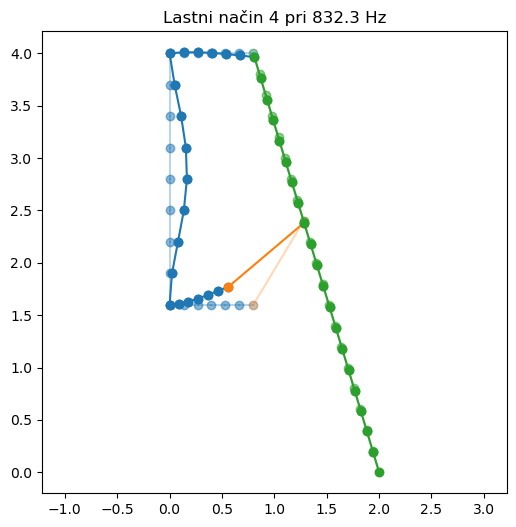

In [191]:
# Izbira lastnega načina
m = 4
# scale faktor
s = 1 

# pomiki strukture A
pomiki_x_A = eig_vec_A[0::3, m].real
pomiki_y_A = eig_vec_A[1::3, m].real

# pomiki strukture C
pomiki_x_C = eig_vec_C[0::3, m].real
pomiki_y_C = eig_vec_C[1::3, m].real

# pomiki strukture B
pomiki_x_B = eig_vec_B[0::2, m].real
pomiki_y_B = eig_vec_B[1::2, m].real

# deformirane koordinate A
def_vozlisca_A = np.copy(vozlisca_A)
def_vozlisca_A[:,0] += pomiki_x_A * s
def_vozlisca_A[:,1] += pomiki_y_A * s

# deformirane koordinate C
def_vozlisca_C = np.copy(vozlisca_C)
def_vozlisca_C[:,0] += pomiki_x_C * s
def_vozlisca_C[:,1] += pomiki_y_C * s

# deformirane koordinate B
def_vozlisca_B = np.copy(vozlisca_B)
def_vozlisca_B[:,0] += pomiki_x_B * s
def_vozlisca_B[:,1] += pomiki_y_B * s
 
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_title(f'Lastni način {m} pri {eig_freq[m].round(1)} Hz')
ax.axis('equal')

# nedeformirano stanje
[ax.plot(*vozlisca_A[e].T, '-o', c='C0', alpha=0.3) for e in elementi_A];
[ax.plot(*vozlisca_B[e].T, '-o', c='C1', alpha=0.3) for e in elementi_B];
[ax.plot(*vozlisca_C[e].T, '-o', c='C2', alpha=0.3) for e in elementi_C];

# deformirano stanje
[ax.plot(*def_vozlisca_A[e].T, '-o', c='C0') for e in elementi_A];
[ax.plot(*def_vozlisca_B[e].T, '-o', c='C1') for e in elementi_B];
[ax.plot(*def_vozlisca_C[e].T, '-o', c='C2') for e in elementi_C];


### Izvoz GIFov prvih N lastnih oblik

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


GIF 0 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 1 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 2 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 3 ustvarjen!
GIF 4 ustvarjen!


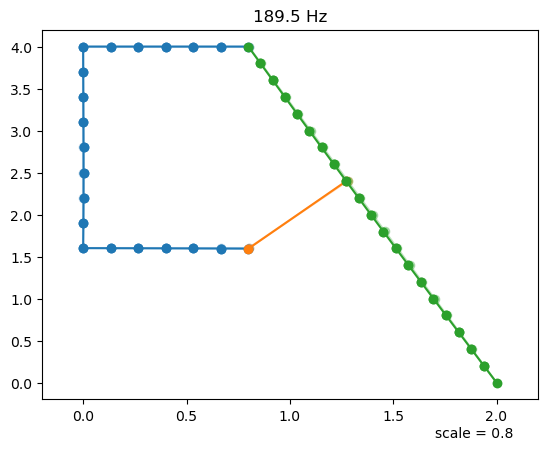

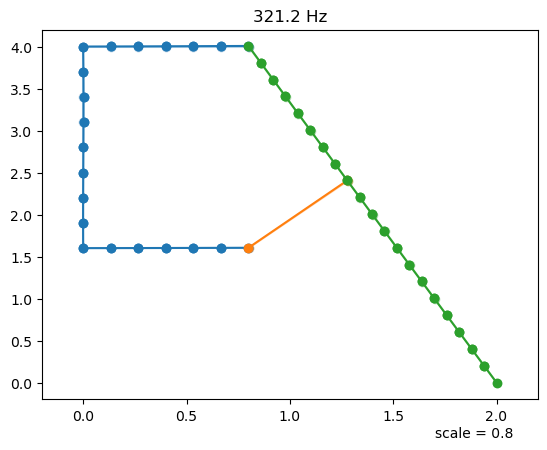

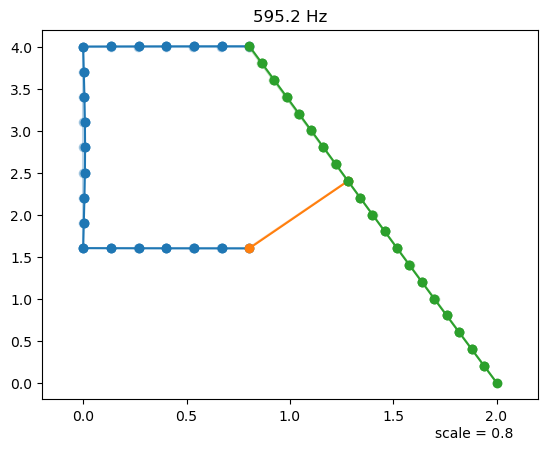

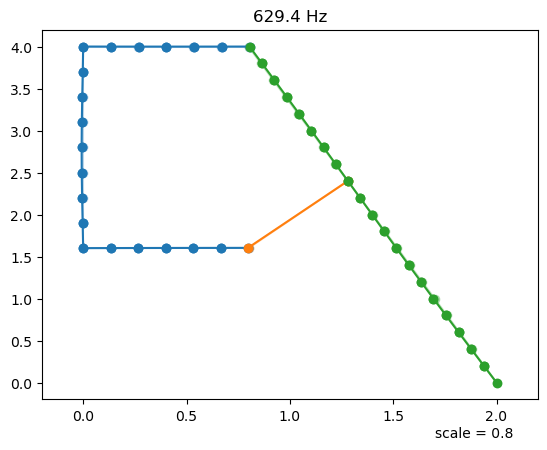

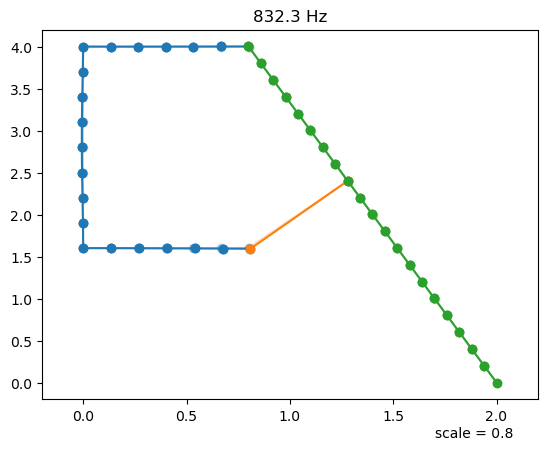

In [197]:
N = 5
for m in np.arange(N):
    s = 0.8

    # podstruktura A
    pomiki_x_A = eig_vec_A[0::3,m].real
    pomiki_y_A = eig_vec_A[1::3,m].real

    # podstruktura B
    pomiki_x_B = eig_vec_B[0::2,m].real
    pomiki_y_B = eig_vec_B[1::2,m].real

    # podstruktura C
    pomiki_x_C = eig_vec_C[0::3,m].real
    pomiki_y_C = eig_vec_C[1::3,m].real

    def_vozlisca_A = np.copy(vozlisca_A)
    def_vozlisca_A[:,0] += pomiki_x_A *s
    def_vozlisca_A[:,1] += pomiki_y_A * s

    def_vozlisca_B = np.copy(vozlisca_B)
    def_vozlisca_B[:,0] += pomiki_x_B *s
    def_vozlisca_B[:,1] += pomiki_y_B * s

    def_vozlisca_C = np.copy(vozlisca_C)
    def_vozlisca_C[:,0] += pomiki_x_C *s
    def_vozlisca_C[:,1] += pomiki_y_C * s

    # Define the undeformed and deformed coordinates
    # undeformed_coords_A = vozlisca_A
    # deformed_coords_A = def_vozlisca_A

    # undeformed_coords_B = vozlisca_B
    # deformed_coords_B = def_vozlisca_B

    # undeformed_coords_C = vozlisca_C
    # deformed_coords_C = def_vozlisca_C

    undeformed_coords = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
    deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_B, def_vozlisca_C))

    # # Calculate the deformation array
    deformation = np.array(deformed_coords) - np.array(undeformed_coords)
    # deformation.shape

    # # Define the number of frames for each deformation direction
    n_frames = 20

    # # Define the animation direction sequence
    directions = [1, -1]

    # # Create a figure and axis object
    fig, ax = plt.subplots()

    # # Create a scatter plot of the undeformed coordinates
    # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], alpha=0.3)

    # Definicija update funkcije
    def update(frame):
        # Najprej počisti prejšnji frame
        ax.clear()
        ax.set_title(f'{eig_freq[m].round(1)} Hz')
        # Prikaz nedeformiranega stanja
        [ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0', alpha=0.3) for i,j in elementi_A]
        ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);
        [ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_B]
        ax.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', alpha=0.3);
        [ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C2', alpha=0.3) for i,j in elementi_C]
        ax.plot(vozlisca_C[:,0],vozlisca_C[:,1],'o', alpha=0.3);
        
        ax.text(0.95, -0.11, f'scale = {s}',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes)

        # Nariše nedeformirane oblike
        # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], color='black', alpha=0.3)
        
        
        ax.set_xlim([-0.2, 2.2])
        ax.set_ylim([-0.2, 4.2])
        direction = directions[frame // (2 * n_frames)]
        frame = frame % (2 * n_frames)
        alpha = frame / n_frames if frame < n_frames else (2 * n_frames - frame) / n_frames
        factor = direction * alpha
        
        # Calculate the current coordinates based on the current deformation factor
        coords = [[u[0] + factor * d[0], u[1] + factor * d[1]] for u, d in zip(undeformed_coords, deformation)]
        
        # Update the scatter plot with the current coordinates
        scatter.set_offsets((coords));
        v_A = np.array(coords[:len(vozlisca_A)])
        v_B = np.array(coords[len(vozlisca_A):len(vozlisca_A)+len(vozlisca_B)])
        v_C = np.array(coords[-len(vozlisca_C):])
        
        [ax.plot(v_A[[i,j],0],v_A[[i,j],1],'-o',c='C0', alpha=1) for i,j in elementi_A];
        [ax.plot(v_B[[i,j],0],v_B[[i,j],1],'-o',c='C1', alpha=1) for i,j in elementi_B];
        [ax.plot(v_C[[i,j],0],v_C[[i,j],1],'-o',c='C2', alpha=1) for i,j in elementi_C];
        
        
        
        # Return the scatter plot for this frame
        return scatter,

    # Define the total number of frames for the animations
    total_frames = 4 * n_frames;

    # Create the animation object
    animation = FuncAnimation(fig, update, frames=total_frames, interval=50);

    # Shranimo GIFe
    animation.save(f'Mode_{m}.gif', writer='imagemagick');
    print(f'GIF {m} ustvarjen!')


## Harmonska analiza

In [201]:
# Določitev vzbujanja
#amplituda vzbujevalnih sil
FCx = 586
FCy = 247

f_glob = np.zeros(3*len(vozlisca_A) + 2*len(vozlisca_B) + 3*len(vozlisca_C)) # pazimo na robne pogoje

ind_voz=len(vozlisca_A)-2 #tocka vzbujanja
ind_x, ind_y, ind_phi = 3*ind_voz+np.array([0,1,2]) #prostostne stopnje vzbujanja
f_glob[ind_x] = FCx
f_glob[ind_y] = FCy

# f_glob = f_glob[proste_ps] #odstranimo vpete - robni pogoji